## Computing the power spectral density

In order to compute the average bandpower in the delta band, we first need to compute an estimate of the power spectral density. The most widely-used method to do that is the Welch's periodogram, which consists in averaging consecutive Fourier transform of small windows of the signal, with or without overlapping. 

A classic periodogram requires the spectral content of the signal to be stationnary (i.e. time-unvarying) over the time period considered. Because it is never the case, the periodogram is generally biased and contains way too much variance (see the end of this tutorial). By averaging the periodograms obtained over short segments of the windows, the Welch's method allows to drastically reduce this variance. This comes at the cost, however, of a lower frequency resolution.


$$ F_{res} = \frac{F_s}{N} = \frac{F_s}{F_st} = \frac{1}{t} $$

How do we define the optimal window duration then? 

A commonly used approach is to take a window sufficiently long to encompasses at least two full cycles of the lowest frequency of interest.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set(font_scale=1.2)
import scipy.signal

In [2]:
path = "/Users/ecem/Desktop/phonocardiogram/data/AV/absent"

In [3]:
waves = np.load(path + "/absent_AV_waves_10sec.npy", allow_pickle= True)

In [4]:
n = waves.shape[0]

In [5]:
f, Pxx = scipy.signal.welch(waves[1], fs=4000)
f.shape

(129,)

 Summation or integration of the spectral components yields the total power (for a physical process) or variance (in a statistical process), identical to what would be obtained by integrating
$${\displaystyle x^{2}(t)}$$ over the time domain

In [6]:
np.logspace(start = 0, stop = 3.3, num =30, dtype = int)

array([   1,    1,    1,    2,    2,    3,    4,    6,    8,   10,   13,
         17,   23,   30,   39,   50,   66,   85,  111,  145,  188,  245,
        318,  414,  538,  699,  909, 1181, 1535, 1995])

In [7]:
def bandpower_logsteps(x, fs, num_of_chunk = 20):
    
    f, Pxx = scipy.signal.welch(x, fs=fs)
    
    steps = np.logspace(start = 0, stop = 3.3, num = num_of_chunk)
    
    bandpowers = np.zeros((num_of_chunk-1))
    
    for i in range(num_of_chunk - 1):
        fmin = float(steps[i])
        fmax = float(steps[i+1])
        
        ind_min = np.argmax(f > fmin) - 1
        ind_max = np.argmax(f > fmax) - 1
        bandpowers[i] =  np.trapz(Pxx[ind_min:ind_max], f[ind_min:ind_max])
    return bandpowers

In [8]:
bandpower_logsteps(waves[20], 4000, 30)

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.04869224e-05, 9.03959840e-06, 2.84219159e-06,
       3.55073276e-07, 2.00229788e-07, 4.11330824e-09, 5.81454085e-13,
       1.24575514e-13, 3.33561780e-14, 7.52789082e-15, 1.79886931e-15,
       2.21620677e-16])

In [9]:
bp = np.empty((n, 29))
for i in range(n):
    bp[i,:] = bandpower_logsteps(waves[i], 4000, 30)

In [10]:
#sanity check
bp[20]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.04869224e-05, 9.03959840e-06, 2.84219159e-06,
       3.55073276e-07, 2.00229788e-07, 4.11330824e-09, 5.81454085e-13,
       1.24575514e-13, 3.33561780e-14, 7.52789082e-15, 1.79886931e-15,
       2.21620677e-16])

## Autocorrelation

In [11]:
from scipy import signal
from scipy.signal import find_peaks

In [12]:
autocorr = signal.fftconvolve(waves[0], waves[0], mode='same')
autocorr_norm = autocorr / np.linalg.norm(autocorr )

In [13]:
autocorr.shape

(40000,)

In [14]:
len(waves[0])

40000

/var/folders/gd/3d6ckpdn4q30skhxnvs_p7b80000gn/T/ipykernel_2266/2127519553.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


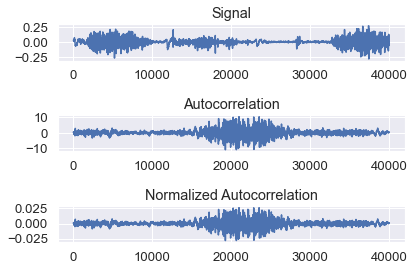

In [15]:
import matplotlib.pyplot as plt
>>> fig, (ax_orig, ax_mag, ax_norm) = plt.subplots(3, 1)
>>> ax_orig.plot(waves[0])
>>> ax_orig.set_title('Signal')
>>> ax_mag.plot(np.arange(0,len(waves[0])), autocorr)
>>> ax_mag.set_title('Autocorrelation')
>>> ax_norm.plot(np.arange(0,len(waves[0])), autocorr_norm)
>>> ax_norm.set_title('Normalized Autocorrelation')
>>> fig.tight_layout()
>>> fig.show()

In [16]:
peaks = find_peaks(autocorr_norm, height = 0.02)

In [17]:
peaks[1]["peak_heights"].max()

0.0271002147346735

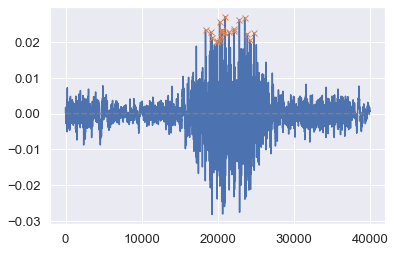

In [18]:
>>> plt.plot( autocorr_norm)
>>> plt.plot(peaks[0], autocorr_norm[peaks[0]], "x")
>>> plt.plot(np.zeros_like(autocorr_norm), "--", color="gray")
>>> plt.show()

In [24]:
maxx = np.empty((n))
minn = np.empty((n))
summ = 0
for i in range(waves.shape[0]):
    auto_corr = signal.fftconvolve(waves[i], waves[i], mode='same')
    norm = auto_corr / np.linalg.norm(auto_corr)
    fp = find_peaks(norm, height = 0.01)

    if fp[0].shape[0] == 0:
        summ +=1
        pass
    else:
        maxx[i] = find_peaks(norm, height = 0.01)[1]["peak_heights"].max()
        minn[i] = find_peaks(norm, height = 0.01)[1]["peak_heights"].min()

In [25]:
summ

18

## create dataframe

In [26]:
import pandas as pd

In [27]:
max_df = pd.DataFrame(maxx, columns =["peak max"])
max_df.head()

,peak max
0,0.027100
1,0.035275
2,0.028974
3,0.029652
4,0.027473


In [28]:
min_df = pd.DataFrame(minn, columns =["peak min"])
min_df.head()

,peak min
0,0.010161
1,0.010017
2,0.010062
3,0.010021
4,0.010138


In [29]:
columns = []
for i in range(29):
    columns.append("{}'th bandpower".format(i))

In [30]:
bandpower_df = pd.DataFrame(bp, columns = columns)
bandpower_df.head()

,0'th bandpower,1'th bandpower,2'th bandpower,3'th bandpower,4'th bandpower,5'th bandpower,6'th bandpower,7'th bandpower,8'th bandpower,9'th bandpower,...,19'th bandpower,20'th bandpower,21'th bandpower,22'th bandpower,23'th bandpower,24'th bandpower,25'th bandpower,26'th bandpower,27'th bandpower,28'th bandpower
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000053,0.000010,0.000009,3.265121e-07,4.210925e-12,5.529903e-13,1.289846e-13,2.724183e-14,6.327039e-15,8.109496e-16
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000052,0.000017,0.000010,2.753879e-07,6.346047e-12,7.718027e-13,1.734842e-13,3.600292e-14,8.277378e-15,1.031748e-15
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000020,0.000003,0.000003,6.764560e-08,1.563125e-12,2.653784e-13,6.582897e-14,1.425574e-14,3.347236e-15,4.248359e-16
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000016,0.000001,0.000001,3.453108e-08,1.955522e-12,3.715692e-13,9.396216e-14,2.047324e-14,4.810262e-15,5.972775e-16
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000015,0.000005,0.000004,1.098879e-07,1.791890e-12,2.240197e-13,5.388303e-14,1.166309e-14,2.738178e-15,3.404845e-16


In [31]:
df = pd.concat([max_df, min_df, bandpower_df], axis =1)

In [32]:
df

,peak max,peak min,0'th bandpower,1'th bandpower,2'th bandpower,3'th bandpower,4'th bandpower,5'th bandpower,6'th bandpower,7'th bandpower,...,19'th bandpower,20'th bandpower,21'th bandpower,22'th bandpower,23'th bandpower,24'th bandpower,25'th bandpower,26'th bandpower,27'th bandpower,28'th bandpower
0,0.027100,0.010161,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000053,0.000010,0.000009,3.265121e-07,4.210925e-12,5.529903e-13,1.289846e-13,2.724183e-14,6.327039e-15,8.109496e-16
1,0.035275,0.010017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000052,0.000017,0.000010,2.753879e-07,6.346047e-12,7.718027e-13,1.734842e-13,3.600292e-14,8.277378e-15,1.031748e-15
2,0.028974,0.010062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000020,0.000003,0.000003,6.764560e-08,1.563125e-12,2.653784e-13,6.582897e-14,1.425574e-14,3.347236e-15,4.248359e-16
3,0.029652,0.010021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000016,0.000001,0.000001,3.453108e-08,1.955522e-12,3.715692e-13,9.396216e-14,2.047324e-14,4.810262e-15,5.972775e-16
4,0.027473,0.010138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000015,0.000005,0.000004,1.098879e-07,1.791890e-12,2.240197e-13,5.388303e-14,1.166309e-14,2.738178e-15,3.404845e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6975,0.044759,0.010011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000074,0.000056,0.000042,9.999981e-07,1.392553e-11,6.702303e-13,1.010362e-13,1.743563e-14,3.728060e-15,4.914745e-16
6976,0.047013,0.010047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000011,0.000010,0.000008,1.862940e-07,2.709854e-12,1.498507e-13,2.548142e-14,4.751444e-15,1.049159e-15,1.325548e-16
6977,0.026189,0.010071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000007,0.000007,0.000004,1.174904e-07,1.083572e-12,8.164781e-14,1.750411e-14,3.681776e-15,8.587968e-16,1.067953e-16
6978,0.021934,0.010066,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000005,0.000002,0.000003,1.479159e-07,8.655693e-13,8.123537e-14,1.914232e-14,4.167502e-15,9.827124e-16,1.207894e-16


In [33]:
df.to_csv("/Users/ecem/Desktop/phonocardiogram/data/AV/absent/AV-bandpower-and-peaks.csv" )